In [18]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label={0: 'No', 1: 'Yes'}, label2id={'No': 0, 'Yes': 1})

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [19]:
dataset = load_dataset('imdb', split='test')
in_dist = [{'input_ids': tokenizer.encode(sample['text'], padding='max_length', max_length=128, truncation=True), 'label': sample['label']} for sample in tqdm(dataset)]

Found cached dataset imdb (/ssd4tb/huggingface_cache/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 25000/25000 [00:17<00:00, 1423.11it/s]


In [20]:
# create tensor dataset
in_dist_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in in_dist]), torch.tensor([elem['label'] for elem in in_dist]), torch.tensor(losses))

# create dataloader
in_dist_dataloader = torch.utils.data.DataLoader(in_dist_dataset, batch_size=64)

NameError: name 'losses' is not defined

In [21]:
# measure loss on each datapoint and add to datasets
in_dist_loss = []

device = 1
model.to(device)
model.eval()
criterion = torch.nn.CrossEntropyLoss(reduction='none')

for batch in tqdm(in_dist_dataloader):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(input_ids=input_ids, labels=labels)
        loss = criterion(outputs.logits, labels)

        in_dist_loss += loss.tolist()
        del loss
in_dist_loss = np.array(in_dist_loss)

 17%|█▋        | 67/391 [00:06<00:33,  9.60it/s]


KeyboardInterrupt: 

In [15]:
np.save('dump/bert_imdb_loss.npy', in_dist_loss)

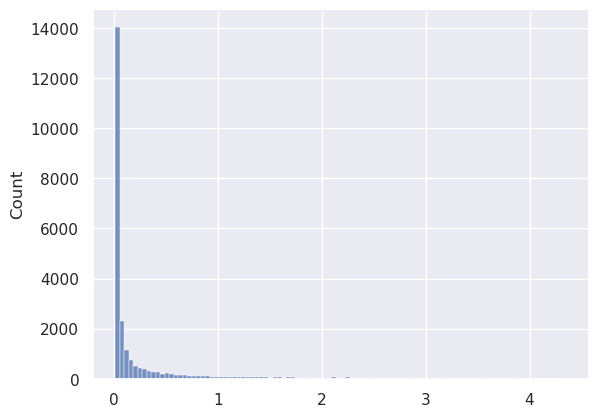

In [22]:
in_dist_loss = np.load('dump/bert_imdb_loss.npy')


sns.histplot(in_dist_loss, bins=100)
plt.show()

In [25]:
dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in in_dist]), torch.tensor([elem['label'] for elem in in_dist]), torch.tensor(in_dist_loss))

In [7]:
in_dist_true = in_dist_dataset.tensors[1] == 1
in_dist_true = in_dist_dataset[in_dist_true]
in_dist_false = in_dist_dataset.tensors[1] == 0
in_dist_false = in_dist_dataset[in_dist_false]

in_dist_true = torch.utils.data.TensorDataset(in_dist_true[0], in_dist_true[1])
in_dist_false = torch.utils.data.TensorDataset(in_dist_false[0], in_dist_false[1])

in_dist_train_size = int(len(in_dist_true)*0.2)

in_dist_train_true, in_dist_val_true = torch.utils.data.random_split(in_dist_true, [in_dist_train_size, len(in_dist_true) - in_dist_train_size])
in_dist_train_false, in_dist_val_false = torch.utils.data.random_split(in_dist_false, [in_dist_train_size, len(in_dist_false) - in_dist_train_size])

in_dist_train = torch.utils.data.ConcatDataset([in_dist_train_true, in_dist_train_false])
in_dist_val = torch.utils.data.ConcatDataset([in_dist_val_true, in_dist_val_false])

# sample 1k for val
in_dist_val = torch.utils.data.Subset(in_dist_val, np.random.choice(len(in_dist_val), 1000, replace=False))

In [8]:
# training loop
# train on in_dist_train_dataset
# eval on in_dist_val_dataset_true, in_dist_val_dataset_false, adv_val_dataset_true, adv_val_dataset_false

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss(reduction='none')

def train(model, optimizer, criterion, train_dataset, train_batch_size, eval_datasets, eval_batch_size, device, num_epochs=1): 
    model.train()
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    batchwise_loss = []
    eval_losses = []

    for epoch in range(num_epochs):
        for i, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss

            # outputs = model(input_ids=input_ids, labels=input_ids)
            # logits = outputs.logits
            # loss = outputs.loss

            # logits = logits[:, :-1, :].contiguous()
            # input_ids = input_ids[:, 1:].contiguous()
            # input_ids = torch.where(input_ids == tokenizer.pad_token_id, -100, input_ids)

            # loss = criterion(logits.view(-1, logits.shape[-1]), input_ids.view(-1)).mean(-1)
            # # labels = batch[1].to(device)
            # # loss = torch.where(labels == 1, loss, 0.1 * -loss)
            # loss = loss.mean()

            # # assert torch.allclose(loss, outputs.loss.mean(), rtol=1e-1), f'{loss} != {outputs.loss.mean()}'
            
            loss = loss.mean()

            loss.backward()
            optimizer.step()

            accuracy = (torch.argmax(outputs.logits, dim=1) == labels).float().mean().item()

            # num_na = 0
            # for p in model.parameters(): 
            #     num_na += torch.sum(torch.isnan(p)).item()
            # print(num_na)

            batchwise_loss.append(accuracy)
            eval_stats = []
            for eval_dataset in eval_datasets:
                eval_acc, eval_tpr, eval_fpr, eval_tnr, eval_fnr = eval_model(model, criterion, eval_dataset, eval_batch_size, device)
                eval_stats.append((eval_acc, eval_tpr, eval_fpr, eval_tnr, eval_fnr))
            eval_losses.append(eval_stats)
            
            # if i % 5 == 0: 
            #     in_dist_true_loss = [elem[0] for elem in eval_losses]
            #     in_dist_false_loss = [elem[1] for elem in eval_losses]
            #     adv_true_loss = [elem[2] for elem in eval_losses]
            #     adv_false_loss = [elem[3] for elem in eval_losses]

            #     sns.set()
            #     sns.lineplot(x=range(len(batchwise_loss)), y=batchwise_loss, label='train')
            #     sns.lineplot(x=range(len(in_dist_true_loss)), y=in_dist_true_loss, label='in_dist_true')
            #     sns.lineplot(x=range(len(in_dist_false_loss)), y=in_dist_false_loss, label='in_dist_false')
            #     sns.lineplot(x=range(len(adv_true_loss)), y=adv_true_loss, label='adv_true')
            #     sns.lineplot(x=range(len(adv_false_loss)), y=adv_false_loss, label='adv_false')
            #     plt.legend()
            #     plt.show()

            if i % 5 == 0:                 
                sns.set()
                sns.lineplot(x=range(len(batchwise_loss)), y=batchwise_loss, label='train')
                sns.lineplot(x=range(len(eval_losses)), y=[elem[0][0] for elem in eval_losses], label='in_dist_val_acc')

                plt.legend()

                plt.show()

        torch.cuda.empty_cache()

    return batchwise_loss, eval_losses
    
def eval_model(model, criterion, eval_dataset, eval_batch_size, device):
    model.eval()
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=eval_batch_size, shuffle=True)
    accuracies = []
    tpr, fpr, tnr, fnr = [], [], [], []
    with torch.no_grad(): 
        for batch in eval_loader: 
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            accuracy = (torch.argmax(outputs.logits, dim=1) == labels).float().mean().item()
            accuracies.append(accuracy)
            tpr.append(((torch.argmax(outputs.logits, dim=1) == labels) & (labels == 1)).float().mean().item())
            fpr.append(((torch.argmax(outputs.logits, dim=1) != labels) & (labels == 0)).float().mean().item())
            tnr.append(((torch.argmax(outputs.logits, dim=1) == labels) & (labels == 0)).float().mean().item())
            fnr.append(((torch.argmax(outputs.logits, dim=1) != labels) & (labels == 1)).float().mean().item())
    return np.mean(accuracies), np.mean(tpr), np.mean(fpr), np.mean(tnr), np.mean(fnr)

In [9]:
# bootstrap_high_size = 1000
# high_frac = 0
# final_train_size = 1000

# high_loss_idxs = np.argsort([elem[2].item() for elem in in_dist_train])[::-1][:bootstrap_high_size]
# high = torch.utils.data.Subset(in_dist_train, high_loss_idxs)
# rem = torch.utils.data.Subset(in_dist_train, np.setdiff1d(np.arange(len(in_dist_train)), high_loss_idxs))

# # sample high_frac of high loss examples
# high = torch.utils.data.Subset(high, np.random.choice(len(high), int(bootstrap_high_size*high_frac)))
# rem = torch.utils.data.Subset(rem, np.random.choice(len(rem), int(bootstrap_high_size*(1-high_frac))))
# to_train = torch.utils.data.ConcatDataset([high, rem])
# to_train = torch.utils.data.Subset(to_train, np.random.choice(len(to_train), final_train_size))

# # # randomly sample target_train_size examples from in_dist_train
# # to_train = torch.utils.data.Subset(in_dist_train, np.random.choice(len(in_dist_train), target_train_size))

# sns.histplot([elem[2].item() for elem in to_train])
# plt.title('In Domain Loss Distribution')
# plt.show()

to_train = in_dist_train

In [10]:
len(to_train), len(in_dist_val)

(5000, 1000)

  0%|          | 0/79 [00:00<?, ?it/s]

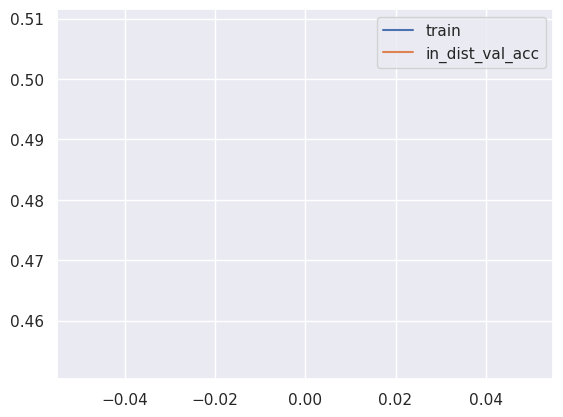

  6%|▋         | 5/79 [00:10<02:34,  2.09s/it]

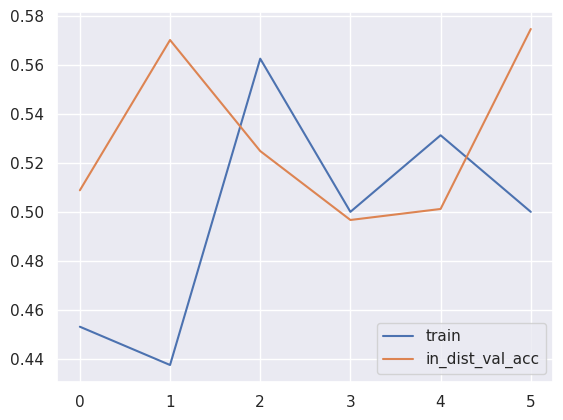

 13%|█▎        | 10/79 [00:21<02:28,  2.15s/it]

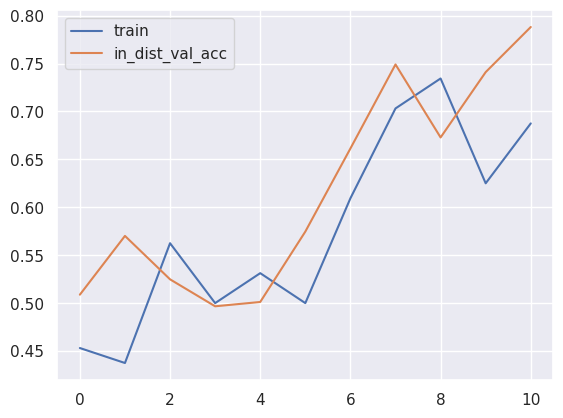

 19%|█▉        | 15/79 [00:32<02:21,  2.21s/it]

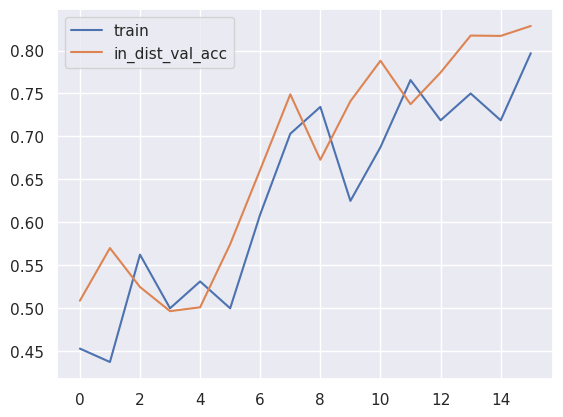

 25%|██▌       | 20/79 [00:43<02:13,  2.27s/it]

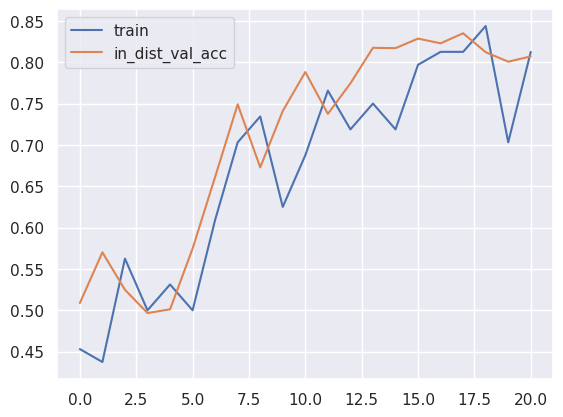

 32%|███▏      | 25/79 [00:55<02:04,  2.30s/it]

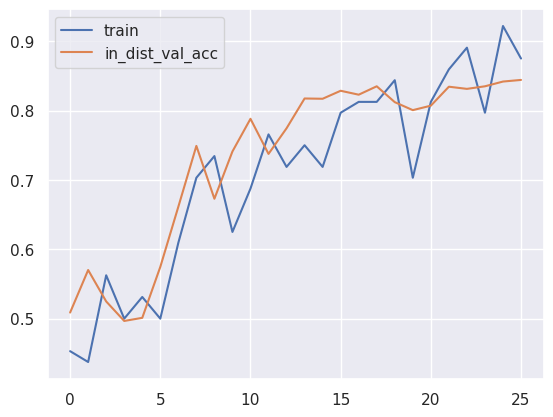

 38%|███▊      | 30/79 [01:07<01:53,  2.32s/it]

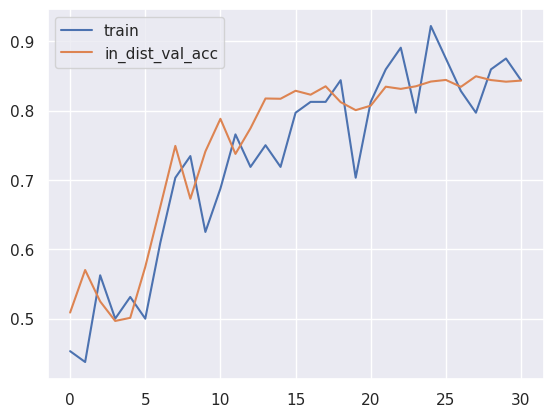

 44%|████▍     | 35/79 [01:19<01:42,  2.34s/it]

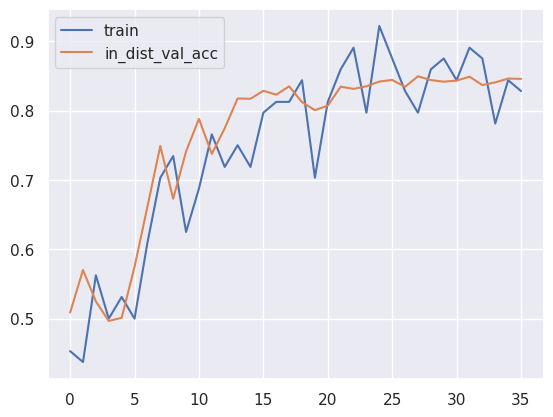

 51%|█████     | 40/79 [01:30<01:31,  2.35s/it]

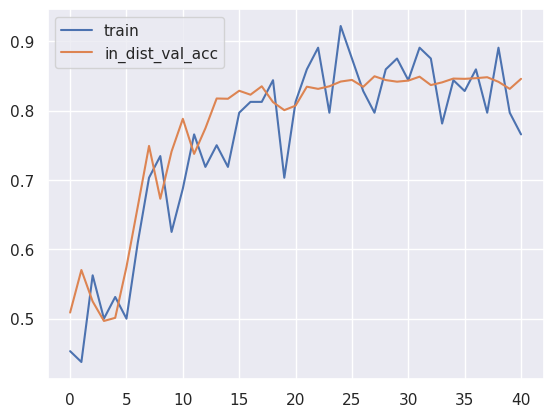

 57%|█████▋    | 45/79 [01:42<01:20,  2.37s/it]

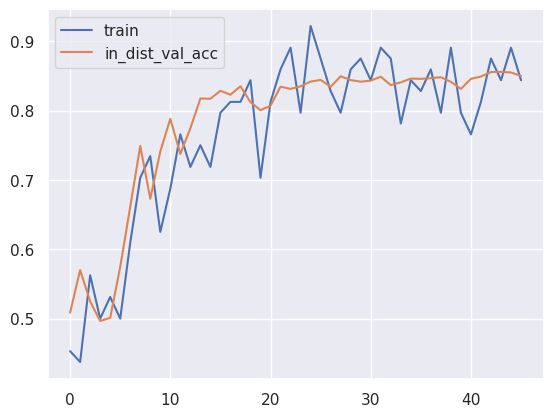

 63%|██████▎   | 50/79 [01:54<01:08,  2.38s/it]

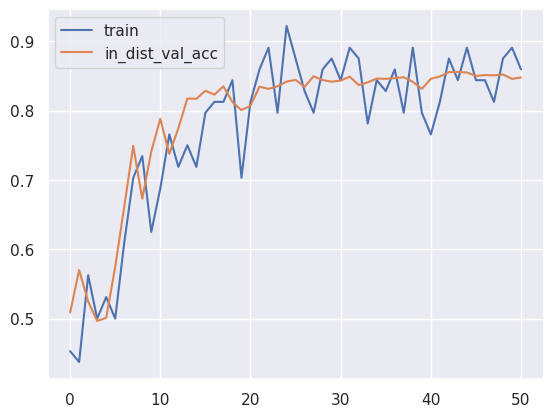

 70%|██████▉   | 55/79 [02:06<00:57,  2.38s/it]

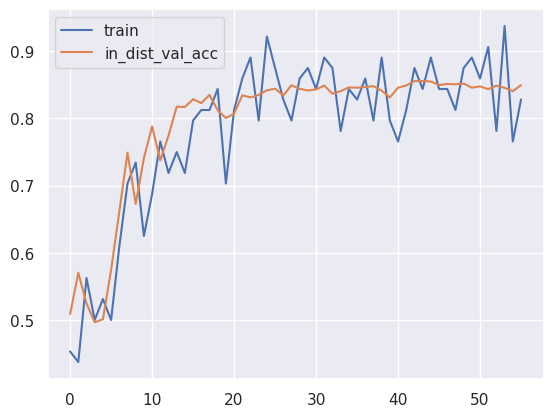

 76%|███████▌  | 60/79 [02:18<00:45,  2.39s/it]

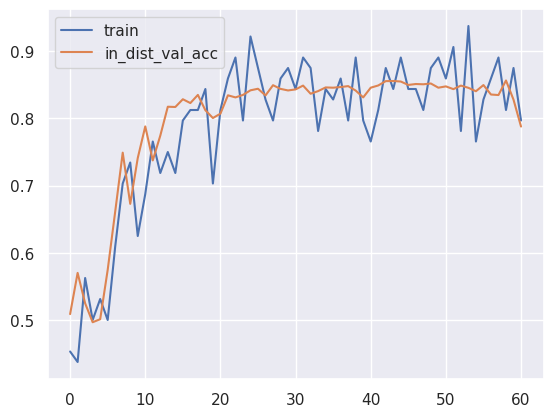

 82%|████████▏ | 65/79 [02:30<00:33,  2.40s/it]

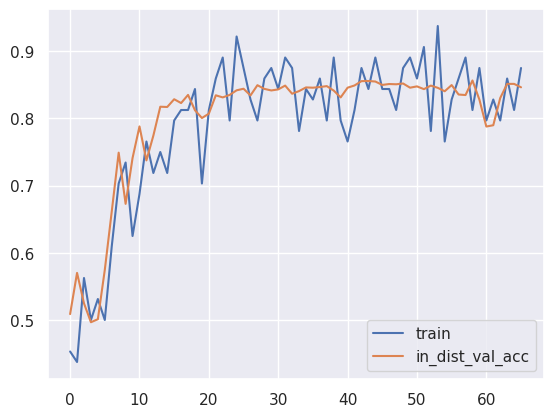

 89%|████████▊ | 70/79 [02:42<00:21,  2.40s/it]

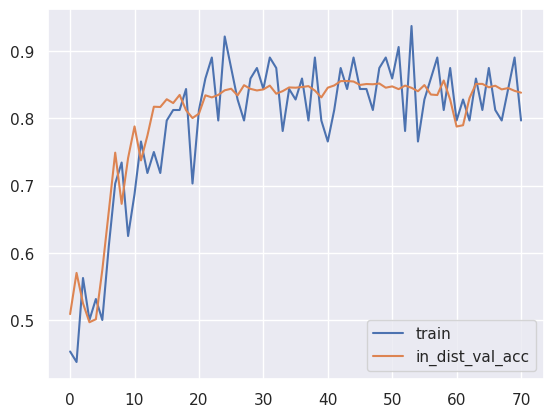

 95%|█████████▍| 75/79 [02:54<00:09,  2.40s/it]

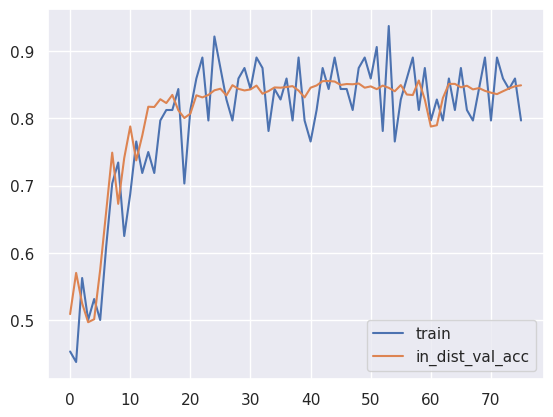

  0%|          | 0/79 [00:00<?, ?it/s]

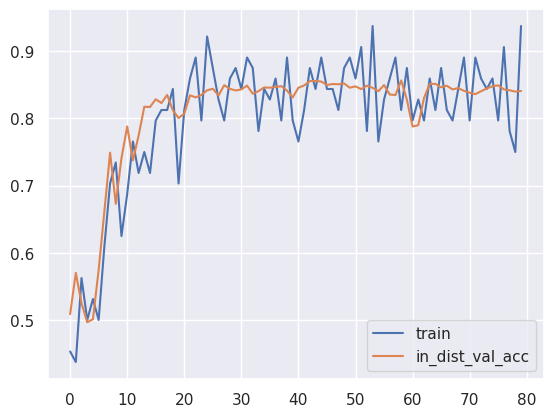

  6%|▋         | 5/79 [00:12<02:58,  2.41s/it]

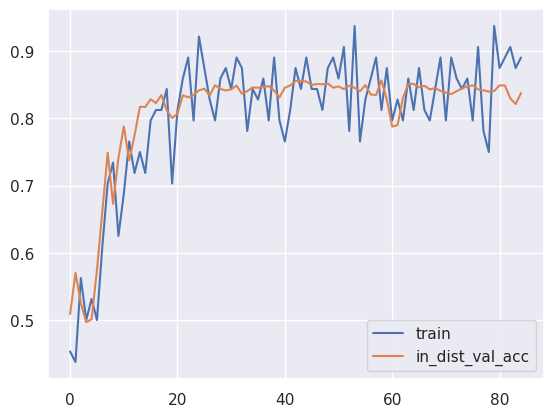

  9%|▉         | 7/79 [00:19<03:17,  2.74s/it]


KeyboardInterrupt: 

In [11]:
train_batch_size = 64
eval_batch_size = 64
device = 1
model.to(device)

train_loss, eval_losses = train(model, optimizer, criterion, to_train, train_batch_size, [in_dist_val], eval_batch_size, device, num_epochs=2)

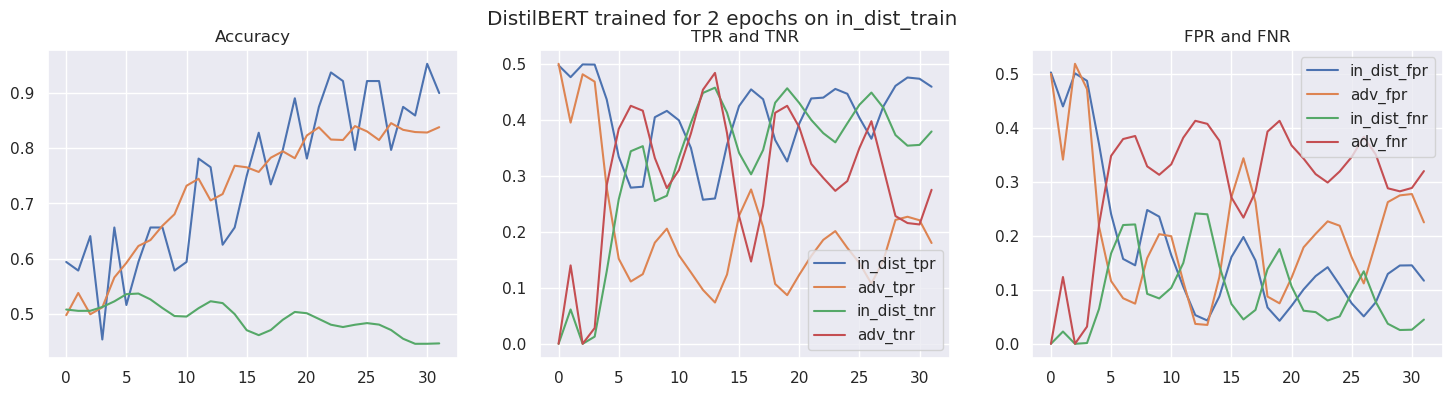

In [ ]:
eval_losses = np.array(eval_losses)
in_dist_acc, in_dist_tpr, in_dist_fpr, in_dist_tnr, in_dist_fnr = eval_losses[:, 0, 0], eval_losses[:, 0, 1], eval_losses[:, 0, 2], eval_losses[:, 0, 3], eval_losses[:, 0, 4]

fig, axs = plt.subplots(1,3, figsize=(18, 4))
sns.set()

sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=axs[0])
sns.lineplot(x=range(len(in_dist_acc)), y=in_dist_acc, label='in_dist_acc', ax=axs[0])
axs[0].set_title('Accuracy')

sns.lineplot(x=range(len(in_dist_tpr)), y=in_dist_tpr, label='in_dist_tpr', ax=axs[1])
sns.lineplot(x=range(len(in_dist_fpr)), y=in_dist_tnr, label='in_dist_tnr', ax=axs[1])
axs[1].set_title('TPR and TNR')

sns.lineplot(x=range(len(in_dist_tnr)), y=in_dist_fpr, label='in_dist_fpr', ax=axs[2])
sns.lineplot(x=range(len(in_dist_fnr)), y=in_dist_fnr, label='in_dist_fnr', ax=axs[2])
axs[2].set_title('FPR and FNR')

plt.suptitle('DistilBERT trained for 2 epochs on in_dist_train')
plt.show()

# save model
model.save_pretrained('distilbert')

### recheck losses

In [ ]:
data_path = '/ssd4tb/huggingface_cache/datasets/adversarial-data/adversarial-data/train'

in_dist = pd.read_csv(os.path.join(data_path, 'initial_in_domain.csv'))
adv = pd.read_csv(os.path.join(data_path, 'manual_adversarial_examples.csv'))

# remove best_label column == 'Unsure'

in_dist = in_dist[in_dist['best_label'] != 'Unsure']
adv = adv[adv['best_label'] != 'Unsure']

print(in_dist['best_label'].value_counts())
print(adv['best_label'].value_counts())

in_dist['text'] = in_dist['prompt'] + ' ' + in_dist['completion'] 
adv['text'] = adv['prompt'] + ' ' + adv['completion']

del in_dist['prompt']
del in_dist['completion']
del adv['prompt']
del adv['completion']

in_dist['label'] = in_dist['best_label'].apply(lambda x: 1 if x == 'Yes' else 0)
adv['label'] = adv['best_label'].apply(lambda x: 1 if x == 'Yes' else 0)

del in_dist['best_label']
del adv['best_label']

No     149296
Yes     17134
Name: best_label, dtype: int64
No     847
Yes    771
Name: best_label, dtype: int64


In [ ]:
in_dist = in_dist.dropna()
adv = adv.dropna()

print(in_dist['label'].value_counts())
print(adv['label'].value_counts())

# balance dataset
min_class = min(in_dist['label'].value_counts())
min_adv_class = min(adv['label'].value_counts())
in_dist = pd.concat([in_dist[in_dist['label'] == 0].sample(min_class), in_dist[in_dist['label'] == 1].sample(min_class)])
adv = pd.concat([adv[adv['label'] == 0].sample(min_adv_class), adv[adv['label'] == 1].sample(min_adv_class)])

print(in_dist['label'].value_counts())
print(adv['label'].value_counts())

# shuffle 
in_dist = in_dist.sample(frac=1)
adv = adv.sample(frac=1)


0    149296
1     17134
Name: label, dtype: int64
0    844
1    770
Name: label, dtype: int64
0    17134
1    17134
Name: label, dtype: int64
0    770
1    770
Name: label, dtype: int64


In [ ]:
### temp loss calculation 

in_dist = in_dist.dropna()
adv = adv.dropna()

in_dist = in_dist.to_dict('records')
adv = adv.to_dict('records')

# tokenize
in_dist = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label']} for elem in tqdm(in_dist)]
adv = [{'input_ids': tokenizer(elem['text'], padding='max_length', truncation=True, max_length=128)['input_ids'], 'label': elem['label']} for elem in tqdm(adv)]

# create tensor dataset
in_dist_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in in_dist]), torch.tensor([elem['label'] for elem in in_dist]))
adv_dataset = torch.utils.data.TensorDataset(torch.tensor([elem['input_ids'] for elem in adv]), torch.tensor([elem['label'] for elem in adv]))

# create dataloader
in_dist_dataloader = torch.utils.data.DataLoader(in_dist_dataset, batch_size=128)
adv_dataloader = torch.utils.data.DataLoader(adv_dataset, batch_size=128)

# measure loss on each datapoint and add to datasets
in_dist_loss = []
adv_loss = []

device = 0
model.to(device)
model.eval()
criterion = torch.nn.CrossEntropyLoss(reduction='none')

tokenizer.pad_token = tokenizer.eos_token

for batch in tqdm(in_dist_dataloader):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(input_ids=input_ids, labels=labels)
        loss = criterion(outputs.logits, labels)

        in_dist_loss += loss.tolist()
        del loss
        
for batch in tqdm(adv_dataloader):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        labels = batch[1].to(device)

        outputs = model(input_ids=input_ids, labels=labels)
        loss = criterion(outputs.logits, labels)
        
        adv_loss += loss.tolist()
        del loss

in_dist_loss = np.array(in_dist_loss)
adv_loss = np.array(adv_loss)

100%|██████████| 13/13 [00:02<00:00,  4.92it/s]


In [ ]:
np.save('bert_ft_in_dist_loss.npy', in_dist_loss)
np.save('bert_ft_adv_loss.npy', adv_loss)

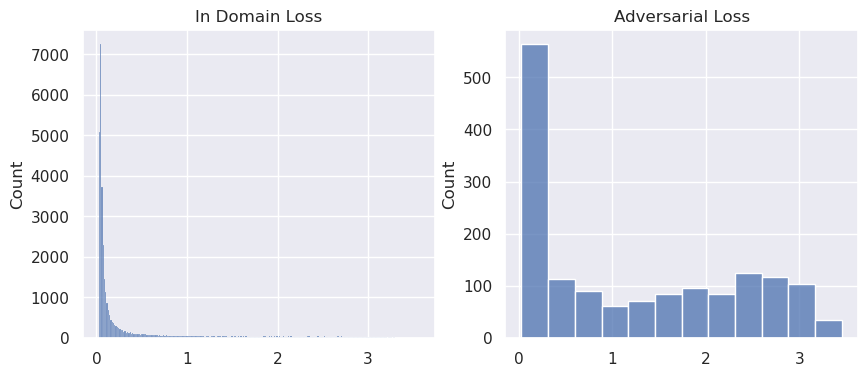

In [ ]:
in_dist_loss = np.load('bert_ft_in_dist_loss.npy')
adv_loss = np.load('bert_ft_adv_loss.npy')


fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(in_dist_loss, ax=axs[0])
sns.histplot(adv_loss, ax=axs[1])
axs[0].set_title('In Domain Loss')
axs[1].set_title('Adversarial Loss')
plt.show()

## run previous data preprocessing cells ## 

In [ ]:
# in_dist = in_dist.to_dict('records')
# adv = adv.to_dict('records')

# each elem looks like {'text': "wakens  \n  \n  \nThe harsh light of the midday sun cascaded over the young Mr. Quest's sleeping form. As the light slowly penetrated the skin of his eyelids a bit he stirred, obviously being roused (albeit slowly) from his peaceful slumber. But for once, even this short period of light did not bother him.",
#   'label': 0},

# tokenize
in_dist = [{'input_ids': elem['input_ids'], 'label': elem['label'], 'loss': loss} for elem, loss in tqdm(zip(in_dist, in_dist_loss))]
adv = [{'input_ids': elem['input_ids'], 'label': elem['label'], 'loss': loss} for elem, loss in tqdm(zip(adv, adv_loss))]

34268it [00:00, 182908.03it/s]
1540it [00:00, 2133871.21it/s]


### adversarial finetuning

In [ ]:
from copy import deepcopy

rmodel = deepcopy(model)

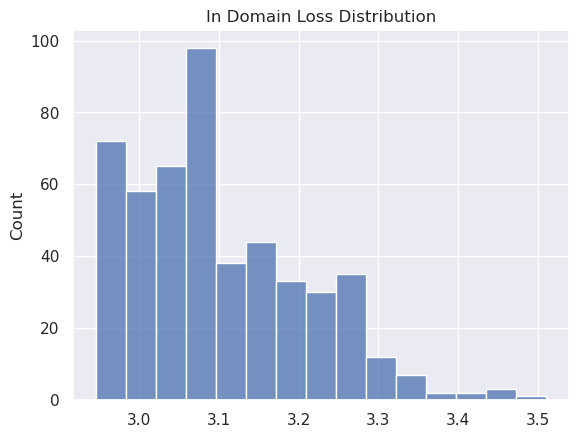

In [ ]:
bootstrap_high_size = 500
high_frac = 1
final_train_size = 500

high_loss_idxs = np.argsort([elem[2].item() for elem in in_dist_train])[::-1][:bootstrap_high_size]
high = torch.utils.data.Subset(in_dist_train, high_loss_idxs)
rem = torch.utils.data.Subset(in_dist_train, np.setdiff1d(np.arange(len(in_dist_train)), high_loss_idxs))

# sample high_frac of high loss examples
high = torch.utils.data.Subset(high, np.random.choice(len(high), int(bootstrap_high_size*high_frac)))
rem = torch.utils.data.Subset(rem, np.random.choice(len(rem), int(bootstrap_high_size*(1-high_frac))))
to_train = torch.utils.data.ConcatDataset([high, rem])
to_train = torch.utils.data.Subset(to_train, np.random.choice(len(to_train), final_train_size))

# # randomly sample target_train_size examples from in_dist_train
# to_train = torch.utils.data.Subset(in_dist_train, np.random.choice(len(in_dist_train), target_train_size))

sns.histplot([elem[2].item() for elem in to_train])
plt.title('In Domain Loss Distribution')
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

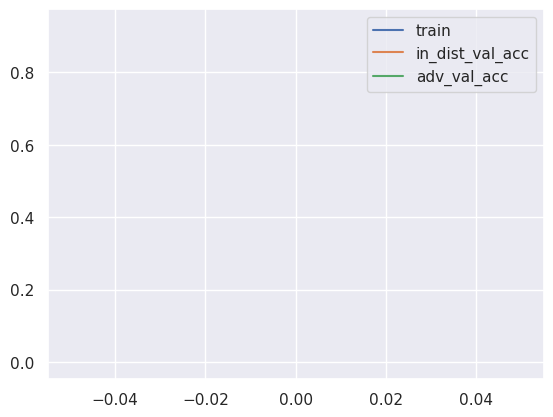

 31%|███▏      | 5/16 [00:09<00:19,  1.79s/it]

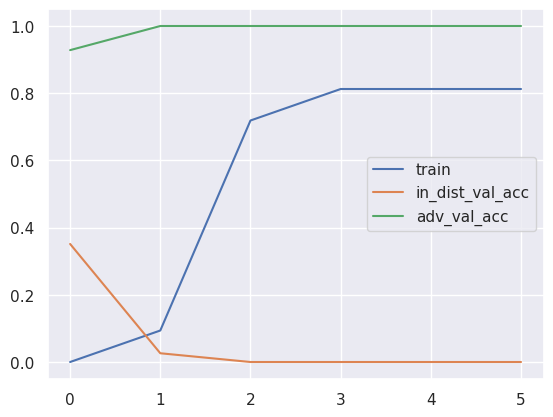

 62%|██████▎   | 10/16 [00:19<00:10,  1.83s/it]

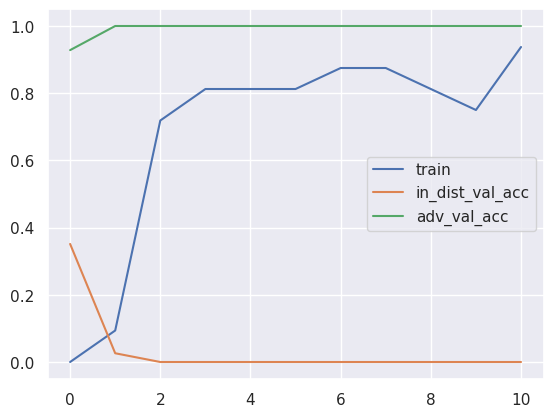

 94%|█████████▍| 15/16 [00:29<00:01,  1.87s/it]

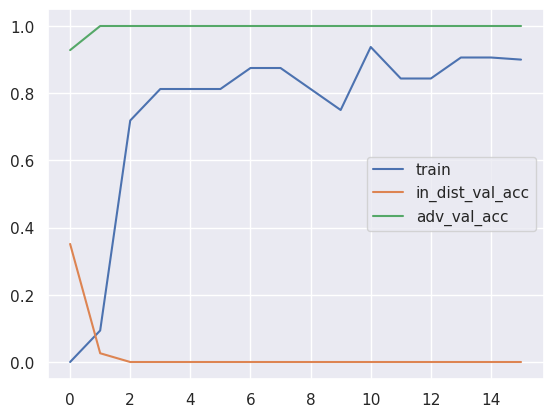

100%|██████████| 16/16 [00:32<00:00,  2.04s/it]


In [ ]:
# just train for 1 epoch, evaluate on all datasets

train_batch_size = 32
eval_batch_size = 64
device = 0
model = model.to(device)

optimizer = torch.optim.Adam(rmodel.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss(reduction='none')

train_loss, eval_losses = train(rmodel, optimizer, criterion, to_train, train_batch_size, [in_dist_val_true, in_dist_val_false, adv_val_true, adv_val_false], eval_batch_size, device, num_epochs=1)

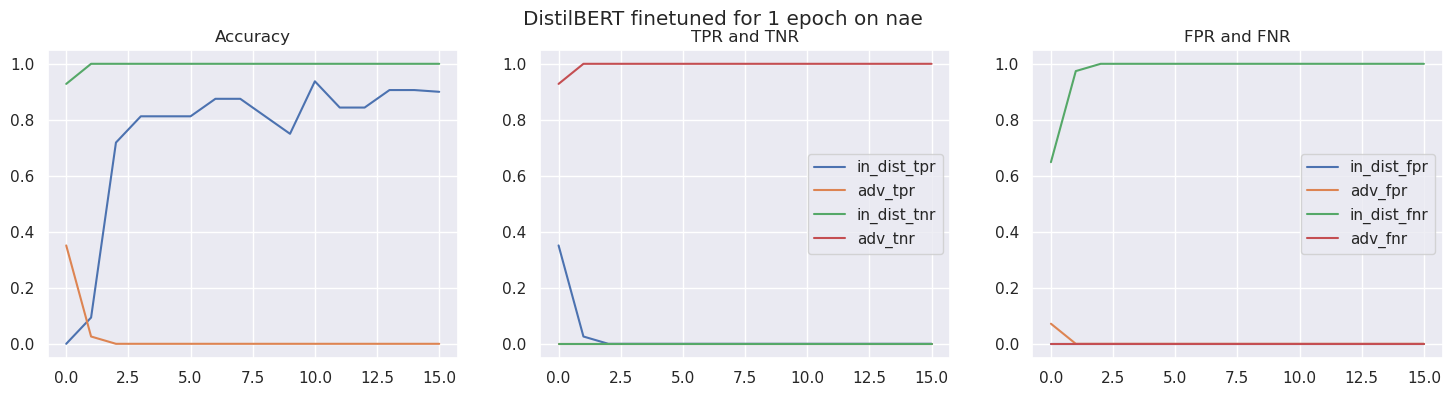

In [ ]:
eval_losses = np.array(eval_losses)

in_dist_acc, in_dist_tpr, in_dist_fpr, in_dist_tnr, in_dist_fnr = eval_losses[:, 0, 0], eval_losses[:, 0, 1], eval_losses[:, 0, 2], eval_losses[:, 0, 3], eval_losses[:, 0, 4]
adv_acc, adv_tpr, adv_fpr, adv_tnr, adv_fnr = eval_losses[:, 1, 0], eval_losses[:, 1, 1], eval_losses[:, 1, 2], eval_losses[:, 1, 3], eval_losses[:, 1, 4]

# create 3 x 1 plots

import statsmodels.api as sm

fig, axs = plt.subplots(1,3, figsize=(18, 4))
sns.set()

lowess = sm.nonparametric.lowess(train_loss, range(len(train_loss)), frac=0.01)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0])
lowess = sm.nonparametric.lowess(in_dist_acc, range(len(in_dist_acc)), frac=0.01)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0])
lowess = sm.nonparametric.lowess(adv_acc, range(len(adv_acc)), frac=.2)
sns.lineplot(x=lowess[:, 0], y=lowess[:, 1], ax=axs[0])

axs[0].set_title('Accuracy')

sns.lineplot(x=range(len(in_dist_tpr)), y=in_dist_tpr, label='in_dist_tpr', ax=axs[1])
sns.lineplot(x=range(len(adv_tpr)), y=adv_tpr, label='adv_tpr', ax=axs[1])
sns.lineplot(x=range(len(in_dist_fpr)), y=in_dist_tnr, label='in_dist_tnr', ax=axs[1])
sns.lineplot(x=range(len(adv_fpr)), y=adv_tnr, label='adv_tnr', ax=axs[1])
axs[1].set_title('TPR and TNR')

sns.lineplot(x=range(len(in_dist_tnr)), y=in_dist_fpr, label='in_dist_fpr', ax=axs[2])
sns.lineplot(x=range(len(adv_tnr)), y=adv_fpr, label='adv_fpr', ax=axs[2])
sns.lineplot(x=range(len(in_dist_fnr)), y=in_dist_fnr, label='in_dist_fnr', ax=axs[2])
sns.lineplot(x=range(len(adv_fnr)), y=adv_fnr, label='adv_fnr', ax=axs[2])
axs[2].set_title('FPR and FNR')

plt.suptitle('DistilBERT finetuned for 1 epoch on nae')
plt.show()

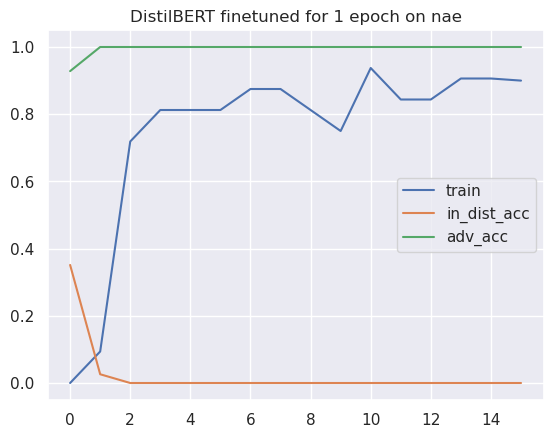

In [ ]:
sns.lineplot(x=range(len(train_loss)), y=train_loss, label='train')
sns.lineplot(x=range(len(in_dist_acc)), y=in_dist_acc, label='in_dist_acc')
sns.lineplot(x=range(len(adv_acc)), y=adv_acc, label='adv_acc')
plt.title('DistilBERT finetuned for 1 epoch on nae')
plt.show()


In [ ]:
# save in_dist_dataset and val_dataset

torch.save(in_dist_dataset, 'bert_in_dist_dataset.pt')
torch.save(adv_dataset, 'bert_adv_dataset.pt')

### deprecated